# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# -----------------------------------------------------------------------------------------------------------

## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import calendar
from sklearn.cluster import KMeans
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
#-------------------------------------------------------------------------------------------------------------------------#
seed = 666

## Preprocess data

In [2]:
data = pd.read_csv('eshop.csv')
data.head(5)

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


In order to be able to sort and subtract dates, I converted the **Date** column to type datetime and consequently sorted it in order to be able to extract the most recent transaction (to be used as current date).

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', ascending=False, inplace=True)

last_transaction = data.iloc[0]['Date']
print(f'Last recorded transaction took place on: {last_transaction}')

Last recorded transaction took place on: 2015-12-19 00:00:00


In order to create the RFM table, I only need the **Customer ID** and **Date** to find *Recency*. The rest of the parameters will be found with the use of the original dataframe.

In [4]:
rfm = data.drop(['Subtotal', 'Country'], axis=1)

### Recency

I only need one record per customer, so I drop duplicate Customer IDs and keep the first ones (because the data is sorted in descending order by **Date**, the first record of a customer is always the most recent one). 

I create a new column for *Recency* which is calculated by taking the date associated with the record (so customer's most recent transaction) and subtracting it from the last recorded transaction which I found above, which gives me the number of days since each customer's last transaction.

At this point, I no longer need the column **Date**, so I drop it.

In [5]:
rfm = rfm.drop_duplicates(subset='Customer ID', keep='first')
rfm['Recency'] = rfm['Date'].apply(lambda x: (last_transaction - x).days)
rfm = rfm.drop(['Date'], axis=1)

### Frequency

I group the customers by their IDs and count the number of records in each group, which gives me the amount of transactions for the given customer. I save this column as *Frequency* and left merge it with the RFM table, which assigns the resulting frequency to its corresponding Customer ID.

In [6]:
counts = data.groupby('Customer ID').count()['Date'].rename('Frequency')
rfm = rfm.merge(counts, how='left', on='Customer ID')

### Monetary

Once again, I group the data by Customer IDs and select the **Subtotal** column, on which I use the aggregation sum() function to get the total spendings of each customer. I name this column *Monetary* and once again merge it with the RFM table, so now each customer has a record of the number of days since their most recent purchase, the number of purchases made by him/her and the total spendings on the eshop.

In [7]:
totals = data.groupby('Customer ID')['Subtotal'].sum().rename('Monetary')
rfm = rfm.merge(totals, how='left', on='Customer ID')

In [8]:
# Function to display several tables in a row next to each other (works in Jupyter, not on Gitlab)
# source: https://www.xspdf.com/help/50899244.html

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+= df.to_html() + '&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp'
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [9]:
display_side_by_side(rfm.sort_values('Recency').tail(15)[['Customer ID', 'Recency']],
                     rfm.sort_values('Frequency').tail(15)[['Customer ID', 'Frequency']],
                     rfm.sort_values('Monetary').tail(15)[['Customer ID', 'Monetary']])

,Customer ID,Recency
12814,166,3013
12815,30,3025
12816,131,3033
12817,96,3042
12818,67,3043
12819,9,3050
12820,62,3054
12821,82,3069
12822,48,3069
12823,78,3073


## K-Means Clustering

In the process of clustering, we will no longer be needing the Customer ID since from subject matter knowledge, we can safely assume that it has no relation to the customers' behaviour.

In [10]:
rfm_km = rfm.drop(['Customer ID'], axis=1)

K-Means clustering requires the parameter *k* to be known before training the model, so I use the Elbow method to try and estimate which *k* value could be the best for this data.

The best *k* value is such, that *k+1* no longer leads to a significant decrease in the loss function. For K-Means, this loss function is **inertia** which is calculated as the average of the within-cluster sum-of-squares. It simply tells us how internally coherent the clusters are.

I iterate over *k_cnt* values of *k*, perform K-Means clusetring with this parameter and calculate the value of inertia. I then plot the respective inertia values against their *k* values and analyze the graph.

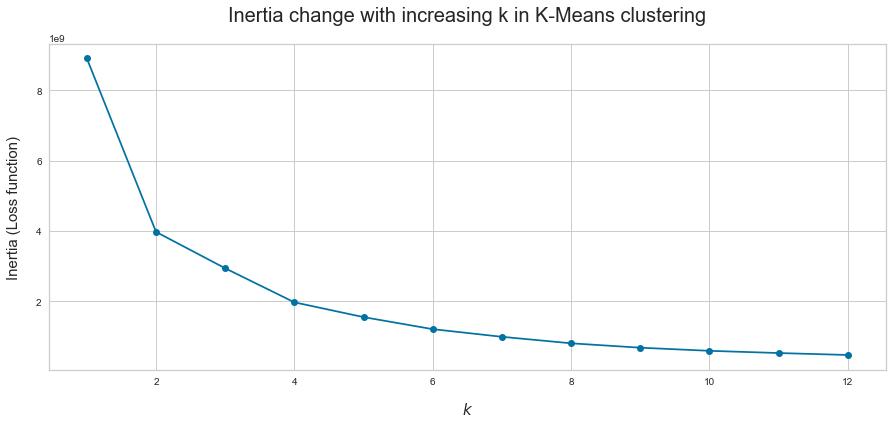

In [11]:
k_cnt = 12

inertias = np.zeros(k_cnt)
for k in range(k_cnt):
    kmeans = KMeans(n_clusters=k+1, random_state=seed)
    kmeans.fit(rfm_km)
    inertias[k] = kmeans.inertia_

plt.figure(figsize=(15,6))
plt.title('Inertia change with increasing k in K-Means clustering', fontsize=20, y=1.05)
plt.xlabel('$k$', fontsize=15, labelpad=15)
plt.ylabel('Inertia (Loss function)', fontsize=15, labelpad=15)
plt.plot(range(1, k_cnt + 1), inertias, 'o-')
plt.show()

Based on this graph, I can tell that the biggest decrease in inertia happens with adding a second cluster, but keeps being significant until reaching roughly the value 5 or 6. That leads me to suspect, that the optimal *k* value for this data will be somewhere around 4 or 5.

In order to test my hypothesis, I use the KElbowVisualizer from the yellowbrick visualization library. The visualizer also analyzes the affect of *k* on the inertia (which it calls distortion score) and saves the value with the strongest inflection point on the curve.

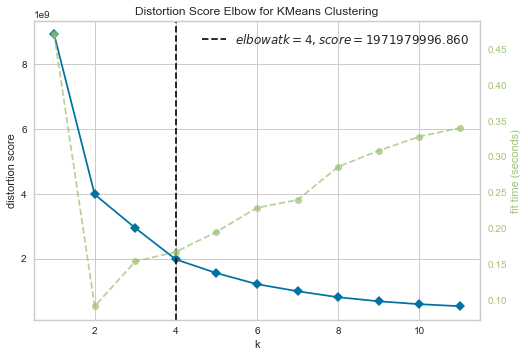

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k=(1,12), metric="distortion")
visualizer.fit(rfm_km)
visualizer.show()

In [13]:
k = visualizer.elbow_value_
print(f'The optimal value of k chosen by the Elbow method with the distortion metric: {k}')

The optimal value of k chosen by the Elbow method with the distortion metric: 4


In [14]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(rfm_km)

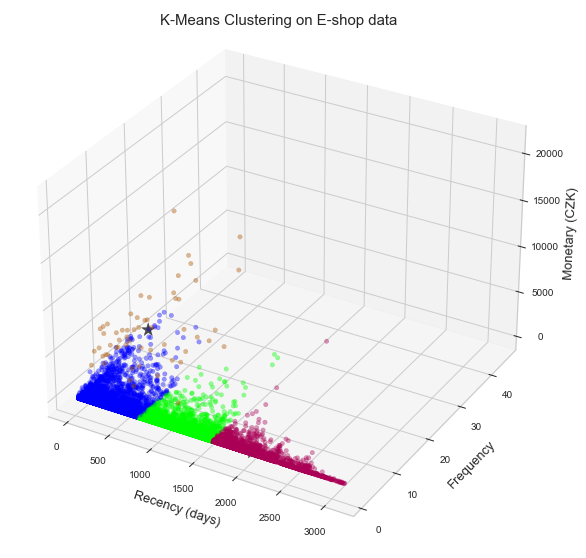

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_km['Recency'], rfm_km['Frequency'], rfm_km['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency (days)', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary (CZK)', fontsize=13, labelpad=10)
plt.show()

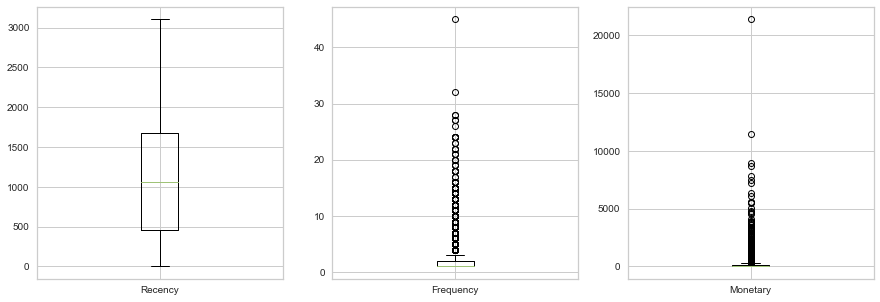

In [16]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].boxplot(rfm_km['Recency'], labels=['Recency'])
axes[1].boxplot(rfm_km['Frequency'], labels=['Frequency'])
axes[2].boxplot(rfm_km['Monetary'], labels=['Monetary'])
plt.show()

Based on this initial experiment where we use K-Means with a *k* of 4 on the original data, I think there may be a good reason to use some sort of scaling first. The *Frequency* and *Monetary* data is very much packed together in a small cluster, with a large amount of outliers. There is very little variation and it may almost impossible for the model to distinguish customers based on these two values. The information about *Recency* is the only one which suggests a more distinguishable normal-like distribution, so I think the model basically just decides which customer belongs to which group based on *Recency* alone.

### Standardization

The first scaling transform that I want to try is standardization, where we transform the data to have a mean of 0 (subtract the mean) and scale it to unit variance (divide by standard deviation).

In [17]:
std_scaler = preprocessing.StandardScaler()
std_rfm = std_scaler.fit_transform(rfm_km)
std_rfm = pd.DataFrame(std_rfm, columns=rfm_km.columns)
std_rfm

,Recency,Frequency,Monetary
0,-1.517677,-0.371483,-0.040975
1,-1.517677,-0.371483,-0.335166
2,-1.516301,-0.371483,0.467084
3,-1.516301,-0.371483,-0.358049
4,-1.516301,-0.371483,-0.205202
...,...,...,...
12824,2.712088,-0.371483,-0.304386
12825,2.721723,-0.371483,-0.364965
12826,2.738240,-0.371483,-0.250919
12827,2.745122,-0.371483,-0.287953


In [18]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(std_rfm)

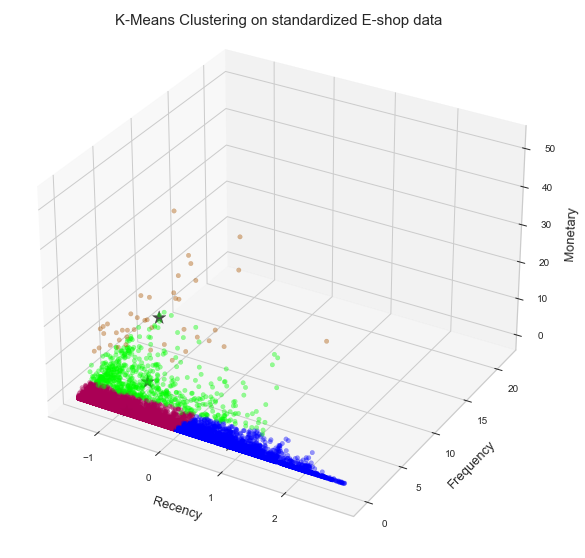

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_rfm['Recency'], std_rfm['Frequency'], std_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on standardized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

Based on the resulting clusters, I think the standardization may have helped in splitting the data. Previously, the three variables had different units and different scales, but now they are directly comparable. Furthermore, even if they had the same units, the difference in variances would have the effect of giving more weight to variables with small variance and the data would be split mostly based on those with greater variance (*Recency*).

### Normalization

Another transform we could use is normalization, where we scale the variables to be between 0 and 1.

In [20]:
minmax_scaler = preprocessing.MinMaxScaler()
norm_rfm = minmax_scaler.fit_transform(rfm_km)
norm_rfm = pd.DataFrame(norm_rfm, columns=rfm_km.columns)
norm_rfm

,Recency,Frequency,Monetary
0,0.000000,0.0,0.006448
1,0.000000,0.0,0.000840
2,0.000322,0.0,0.016131
3,0.000322,0.0,0.000404
4,0.000322,0.0,0.003317
...,...,...,...
12824,0.990332,0.0,0.001427
12825,0.992588,0.0,0.000272
12826,0.996455,0.0,0.002446
12827,0.998066,0.0,0.001740


In [21]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(norm_rfm)

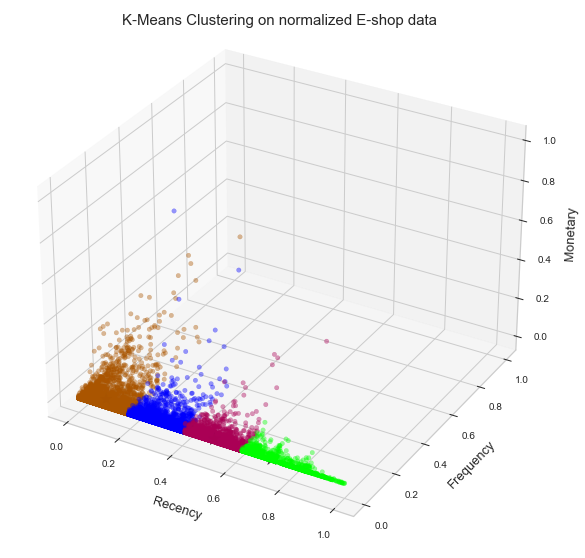

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(norm_rfm['Recency'], norm_rfm['Frequency'], norm_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.4)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.7, s=200, marker='*')

ax.set_title('K-Means Clustering on normalized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

As I mentioned above, the variables now have the same units, but they still have varying variances where *Frequency* and *Monetary* are mostly grouped tightly together. This leads to K-Means splitting the data mostly by the *Recency* variable again.

## Interpretation of the clusters

Since standardization gives us the most reliable comparison between the variables, I will use the standardized RFM table to analyze the resulting clusters of customers and to follow the result of the Elbow method, I will use *k* = 4 *(I have tried the Elbow method on standardized data as well as unscaled and both gave a result of optimal k = 4)* .

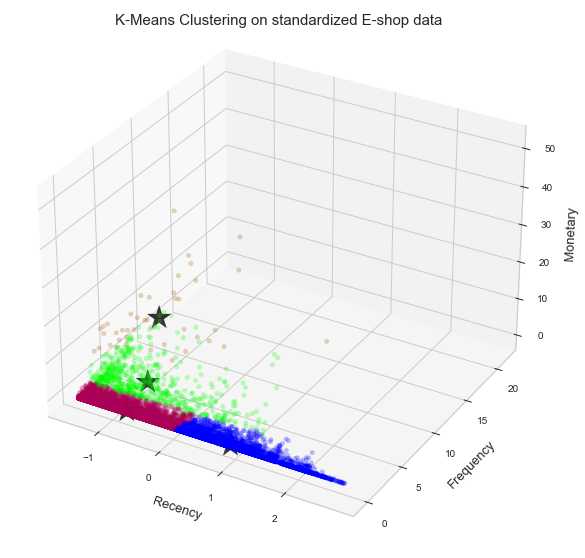

In [23]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=seed).fit(std_rfm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_rfm['Recency'], std_rfm['Frequency'], std_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.25)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.8, s=600, marker='*')

ax.set_title('K-Means Clustering on standardized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

In [24]:
std_rfm['Cluster'] = kmeans.labels_
for cluster in range(k):
    print(f'Cluster {cluster}:')
    display(std_rfm[std_rfm['Cluster'] == cluster].drop(['Cluster'], axis=1).describe())

Cluster 0:


,Recency,Frequency,Monetary
count,5638.000000,5638.000000,5638.000000
mean,0.953542,-0.234440,-0.168610
std,0.568768,0.339783,0.253579
min,0.087238,-0.371483,-0.378111
25%,0.493285,-0.371483,-0.312743
50%,0.888320,-0.371483,-0.252366
75%,1.326024,-0.371483,-0.122721
max,2.753381,2.116122,2.684613


Cluster 1:


,Recency,Frequency,Monetary
count,6537.000000,6537.000000,6537.000000
mean,-0.741565,-0.130904,-0.097199
std,0.488800,0.432203,0.341413
min,-1.517677,-0.371483,-0.379239
25%,-1.176323,-0.371483,-0.298941
50%,-0.760642,-0.371483,-0.213761
75%,-0.321561,0.126038,-0.029202
max,0.212493,1.618601,3.950087


Cluster 2:


,Recency,Frequency,Monetary
count,42.000000,42.000000,42.000000
mean,-1.033469,6.735959,11.793051
std,0.607327,4.428592,8.041850
min,-1.514924,0.126038,4.902044
25%,-1.473632,3.733065,7.562025
50%,-1.349065,5.847529,9.087856
75%,-0.637107,8.583894,13.237866
max,1.001187,21.519439,52.085079


Cluster 3:


,Recency,Frequency,Monetary
count,612.000000,612.000000,612.000000
mean,-0.792569,3.095718,1.782195
std,0.674877,1.791285,1.308455
min,-1.513548,0.126038,-0.212952
25%,-1.366958,2.116122,0.846699
50%,-0.954718,2.613643,1.473820
75%,-0.432707,3.608685,2.424930
max,1.365941,11.071499,6.928711


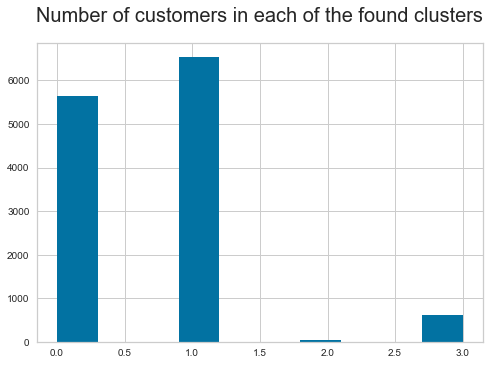

In [25]:
plt.hist(std_rfm['Cluster'])
plt.title('Number of customers in each of the found clusters', fontsize=20, y=1.05)
plt.show()

From analyzing the means of the RFM variables in different clusters, we can make some interesting assumptions.

We can clearly see that the customers that make the most frequent and costly purchases are those in cluster 2. This would be our *Superstar* customers, who also have a low recency, which means the are still active customers (or have been recently). As expected, there is only a handful of them, but identifying them would definitely be of great interest to the eshop since they are the most loyal and valuable.

The next useful cluster is number 1. It is a cluster which groups a large number of customers and specifically those, that have not made many purchases and if so then not very expensive ones. The fact that makes them interesting to the eshop is their low recency. It could mean that they only recently became cusomers and have not had time to make any more significant purchases and establish themselves as regular customers. The eshop could target this cluster with a specific marketing campaign to get them to stay and use the service further.

As for cluster 3, it gives us some insight into the regular standard customers. They use the eshop regularly and have done so recently and their spendings are a good amount. They are also valuable to the eshop, because even though they don't spend as much and as often as the Superstars in cluster 2, they are quite a bit more common.

The fairly *Uninteresting* customers are those in cluster 0. Not only is their purchase frequency and cost on the low side, but their recency is quite high which means it has been a long time since their last transaction. It is likely they used the service once and never really needed it again or were perhaps unhappy and chose one of the competitors for the next time. It is not surprising, that there is also a large amount of such customers.

# -----------------------------------------------------------------------------------------------------------

# Bonus 1

I will try to use Silhouette score analysis of the clusters in order to determine the optimal *k* value for K-Means. 

The Silhouette score of a sample of data is used to describe how dense and well-separated the clusters are. The score ranges from -1 to 1 and reflects the intra-cluster distances among points as well as the inter-cluster distances to the next nearest cluster.

The interpretation of the Silhouette score is as follows:
* 1 - clusters are very dense and well separated
* 0 - there is some overlap among the clusters
* -1 - data belonging to some clusters is wrongly classified

### Silhouette analysis on unscaled data

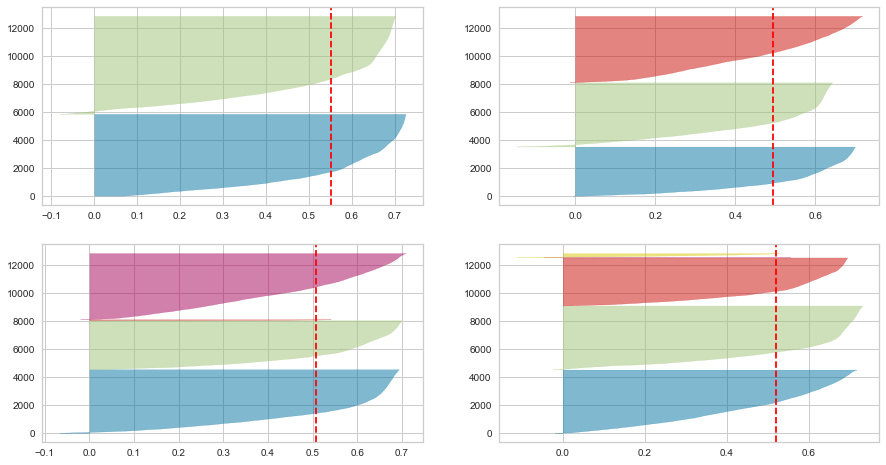

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=seed)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_km)

If for the time being, we only look at the Silhouettes for clusters calculated from the unscaled data, we would most likely go for optimal *k* = 3 which is distributed very uniformly. For *k* greater than 3, we always get 3 pretty similar clusters and one which is so thin that it's almost invisible. For *k* = 2, we get nicely even clusters that score highly on the Silhouette scoring, but since we know that the same can be said for *k* = 3, it is probably missing out on some important subset of customers.

### Silhouette analysis on standardized data

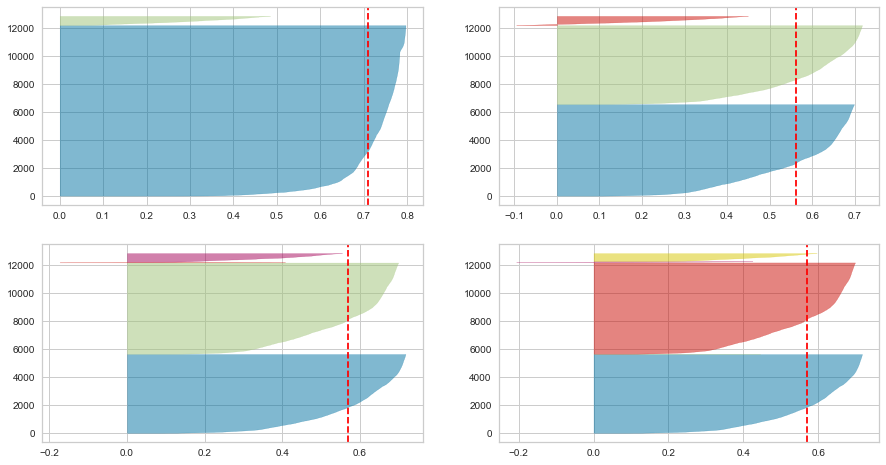

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=seed)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(std_rfm)

The analysis on the standardized data seems to be very different. For *k* of 2, we can clearly see that there is little to no point in distinguishing the customers. One of the clusters scores far below average and the other is several times thicker and such fluctuations are not really what we're looking for. For the other cases of *k*, it can be generally said that there are two main clusters and then a bunch of smaller ones that score below average (so we don't have the option of choosing a *k* which would lead to uniform distribution in the separation). While this may not seem ideal, we have to look at the specific case at hand. From previous analysis and some subject-matter knowledge, we know that there will be a group of *Superstar* customers that will likely not include many people, but it is very beneficial to distinguish them nonetheless. It might not be useful to split this smaller group into more subsets, so I think that a reasonable separation for our example would be using the two main clusters that were found paired along with the one small cluster of a few customers of high importance. Therefore, my conclusion would be to use a *k* value of 3. 

## K-Means Clustering

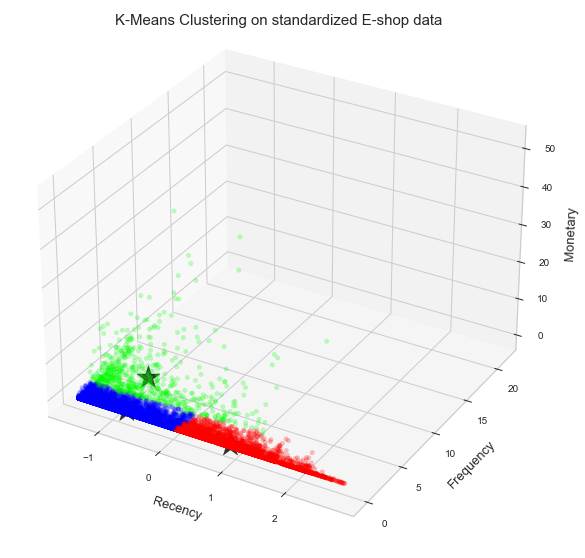

In [28]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=seed).fit(std_rfm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_rfm['Recency'], std_rfm['Frequency'], std_rfm['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.25)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.8, s=600, marker='*')

ax.set_title('K-Means Clustering on standardized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary', fontsize=13, labelpad=10)
plt.show()

In [29]:
std_rfm['Cluster'] = kmeans.labels_
for cluster in range(k):
    print(f'Cluster {cluster}:')
    display(std_rfm[std_rfm['Cluster'] == cluster].drop(['Cluster'], axis=1).describe())

Cluster 0:


,Recency,Frequency,Monetary
count,6537.000000,6537.000000,6537.000000
mean,-0.741565,-0.130904,-0.097199
std,0.488800,0.432203,0.341413
min,-1.517677,-0.371483,-0.379239
25%,-1.176323,-0.371483,-0.298941
50%,-0.760642,-0.371483,-0.213761
75%,-0.321561,0.126038,-0.029202
max,0.212493,1.618601,3.950087


Cluster 1:


,Recency,Frequency,Monetary
count,5638.000000,5638.000000,5638.000000
mean,0.953542,-0.234440,-0.168610
std,0.568768,0.339783,0.253579
min,0.087238,-0.371483,-0.378111
25%,0.493285,-0.371483,-0.312743
50%,0.888320,-0.371483,-0.252366
75%,1.326024,-0.371483,-0.122721
max,2.753381,2.116122,2.684613


Cluster 2:


,Recency,Frequency,Monetary
count,654.000000,654.000000,654.000000
mean,-0.808040,3.329495,2.425094
std,0.672916,2.243056,3.419699
min,-1.514924,0.126038,-0.212952
25%,-1.378314,2.116122,0.877406
50%,-0.962288,2.613643,1.542554
75%,-0.443375,4.106206,2.667126
max,1.365941,21.519439,52.085079


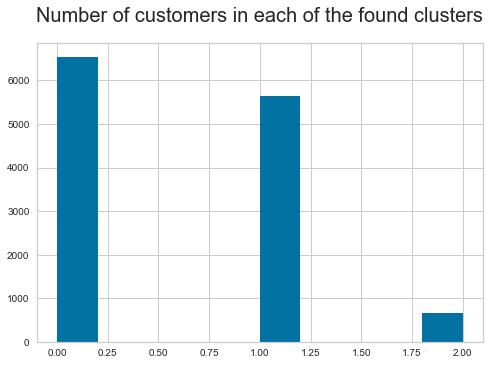

In [30]:
plt.hist(std_rfm['Cluster'])
plt.title('Number of customers in each of the found clusters', fontsize=20, y=1.05)
plt.show()

## Interpretation of the clusters

The results of using *k* of 3 on the standardized data yield results which I think were quite expected and could be very useful to the eshop. 

There is a very large cluster (cluster 0) of recent customers, who have not yet had time to make any larger number of purchases and more expensive purchases.

Another decently size cluster (cluster 1) is for the so-called *Uninteresting* customers which have not made many costly purchases and their activity was last recorded quite a long time ago.

The difference is now in that the last cluster (cluster 2) combined our *Superstar* customers and the pretty good and loyal ones. I think this is beneficial, they both fall into the category of being loyal and valuable generators of profit for the eshop and the fact that some of them do even more is not as needed. We can target them with roughly the similar marketing strategies, so combining them makes sense.

# -----------------------------------------------------------------------------------------------------------

# Bonus 2

## Preprocess data

In [31]:
rfm2 = data.drop(['Country', 'Subtotal'], axis=1)

### Recency

Like in the previous example, I only need the latest transaction for each customer, so I drop duplicity Customer IDs from the data table sorted by **Date**.

I then proceed to create a *Recency* column in the RFM, which is calculated as the maximum of 1 and the number of months since customer's last purchase. I calculate the number of months by taking the days in the timedelta object and dividing them by 30, so it won't be quite exact, but it is a good enough approximation for our use.

In [32]:
rfm2 = rfm2.drop_duplicates(subset='Customer ID', keep='first')
rfm2['Recency'] = rfm2['Date'].apply(lambda x: max(int((last_transaction - x).days / 30), 1))
rfm2 = rfm2.drop(['Date'], axis=1)

### Frequency

In order to make this expandable for finding clusters of customers generally in the last *x* months, I implemented a function which takes a given date and subtracts a given amount of months from it. 

As per this specific task, I subtract 12 months and then go on to filter the data table to only include records that were recorded after the calculated date. I group these results by their Customer IDs and count the number of such records per each customer. This column is then left merged with the RFM table and named *Frequency*. Those customers, that have made no purchase during the last 12 months now have their *Frequency* set to NaN, so I replace missing values with 1 since that is the maximum of 0 and 1.

In [33]:
def subtract_months(date, delta):
    m = (date.month - delta) % 12
    if date.month - delta < 1:
        y = date.year + ((date.month - delta - 1) // 12)
    else: y = date.year
    if m == 0:
        m = 12
    d = min(date.day, calendar.monthrange(y, m)[1]) # either the same day or the max date in the given month
    return datetime.datetime(y, m, d)

x = last_transaction
assert subtract_months(x, 0) == datetime.datetime(x.year, x.month, x.day)
assert subtract_months(x, 3) == datetime.datetime(x.year, x.month - 3, x.day)
assert subtract_months(x, 12) == datetime.datetime(x.year - 1, x.month, x.day)
assert subtract_months(x, 20) == datetime.datetime(x.year - 1, 4, x.day)
assert subtract_months(x, 169) == datetime.datetime(2001, 11, x.day)
assert subtract_months(datetime.datetime(2020, 7, 31), 1049) == datetime.datetime(1933, 2, 28)

In [34]:
last_year_counts = data[data['Date'] > subtract_months(last_transaction, 12)].groupby('Customer ID').count()['Date'].rename('Frequency')
rfm2 = rfm2.merge(last_year_counts, how='left', on='Customer ID').fillna(1)

### Monetary

I find each customer's maximum purchase in the whole dataset by grouping the records by Customer ID and finding the max() in the aggregation. I name this column *Monetary* and left merge it with the RFM table, which includes one record per each customer.

In [35]:
max_subtotal = data.groupby('Customer ID')['Subtotal'].max().rename('Monetary')
rfm2 = rfm2.merge(max_subtotal, how='left', on='Customer ID')

In [36]:
display_side_by_side(rfm2.sort_values('Recency').tail(15)[['Customer ID', 'Recency']],
                     rfm2.sort_values('Frequency').tail(15)[['Customer ID', 'Frequency']],
                     rfm2.sort_values('Monetary').tail(15)[['Customer ID', 'Monetary']])

,Customer ID,Recency
12814,166,100
12815,30,100
12820,62,101
12819,9,101
12817,96,101
12816,131,101
12818,67,101
12821,82,102
12822,48,102
12823,78,102


## K-Means Clustering

In [37]:
rfm2_km = rfm.drop(['Customer ID'], axis=1)

### Standardize

Based on the previous discussion and results, I will once again be standardizing the RFM values.

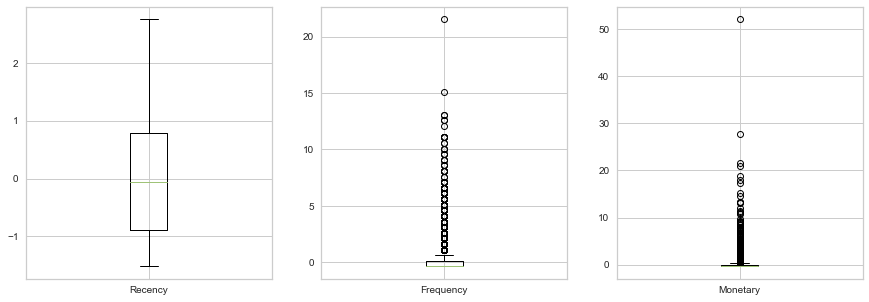

In [38]:
std_scaler = preprocessing.StandardScaler()
std_rfm2 = std_scaler.fit_transform(rfm2_km)
std_rfm2 = pd.DataFrame(std_rfm2, columns=rfm2_km.columns)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].boxplot(std_rfm2['Recency'], labels=['Recency'])
axes[1].boxplot(std_rfm2['Frequency'], labels=['Frequency'])
axes[2].boxplot(std_rfm2['Monetary'], labels=['Monetary'])
plt.show()

### Elbow method

As previously, I first employ the Elbow method in order to determine the optimal *k* value for the K-Means clustering and then the Silhouette method.

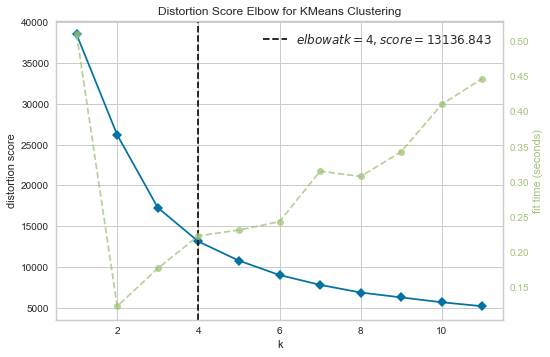

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k=(1,12), metric="distortion")
visualizer.fit(std_rfm2)
visualizer.show()

In [40]:
k = visualizer.elbow_value_
print(f'The optimal value of k chosen by the Elbow method with the distortion metric: {k}')

The optimal value of k chosen by the Elbow method with the distortion metric: 4


### Silhouette method

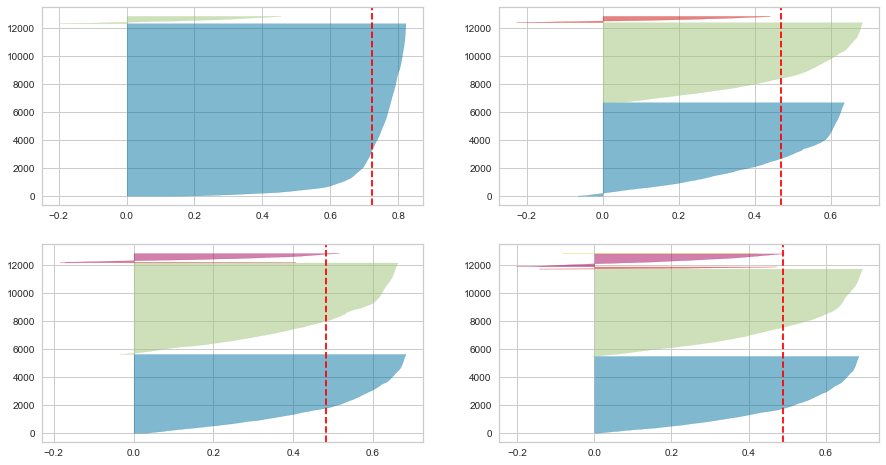

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 6):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=seed)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(std_rfm2)

Upon analyzing the two results, I still think that subject-matter knowledge is very important for this case specifically and grouping the *Superstar* and good customers could be a good option. If I were to go purely by the methods, then maybe *k* = 4 would be the optimal value (Elbow method gives straight up 4 and Silhouette is very similar for 3 and 4 with 3 having a bit higher scores), but the methods do not take into account some factors that could be special for segmenting the eshop customers. Therefore, I will go on with using a *k* of 3.

In [42]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=seed).fit(std_rfm2)

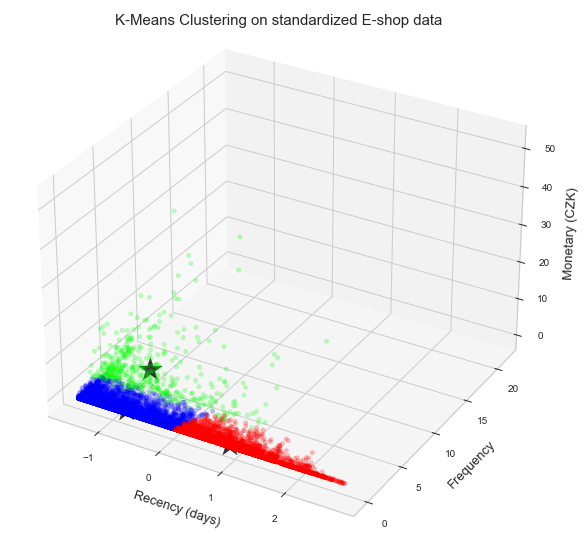

In [43]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(std_rfm2['Recency'], std_rfm2['Frequency'], std_rfm2['Monetary'], c=kmeans.labels_, cmap='brg', alpha=0.25)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
            c='black', alpha=0.8, s=600, marker='*')

ax.set_title('K-Means Clustering on standardized E-shop data', fontsize=15, y=1.04)
ax.set_xlabel('Recency (days)', fontsize=13, labelpad=10)
ax.set_ylabel('Frequency', fontsize=13, labelpad=10)
ax.set_zlabel('Monetary (CZK)', fontsize=13, labelpad=10)
plt.show()

In [44]:
std_rfm2['Cluster'] = kmeans.labels_
for cluster in range(k):
    print(f'Cluster {cluster}:')
    display(std_rfm[std_rfm2['Cluster'] == cluster].drop(['Cluster'], axis=1).describe())

Cluster 0:


,Recency,Frequency,Monetary
count,6675.000000,6675.000000,6675.000000
mean,-0.750749,-0.072449,-0.066865
std,0.486546,0.546563,0.396260
min,-1.517677,-0.371483,-0.379239
25%,-1.183205,-0.371483,-0.297150
50%,-0.778535,-0.371483,-0.206011
75%,-0.336702,0.126038,-0.002359
max,0.332243,2.613643,3.950087


Cluster 1:


,Recency,Frequency,Monetary
count,5709.000000,5709.000000,5709.000000
mean,0.944953,-0.229259,-0.163631
std,0.571556,0.357636,0.273958
min,0.065216,-0.371483,-0.378111
25%,0.475391,-0.371483,-0.312724
50%,0.882814,-0.371483,-0.252145
75%,1.319142,-0.371483,-0.121911
max,2.753381,2.116122,3.457382


Cluster 2:


,Recency,Frequency,Monetary
count,445.000000,445.000000,445.000000
mean,-0.861764,4.027944,3.102235
std,0.660983,2.396633,3.938523
min,-1.514924,0.126038,0.118911
25%,-1.417198,2.613643,1.291971
50%,-1.053821,3.608685,2.095594
75%,-0.477097,5.101248,3.624111
max,1.174617,21.519439,52.085079


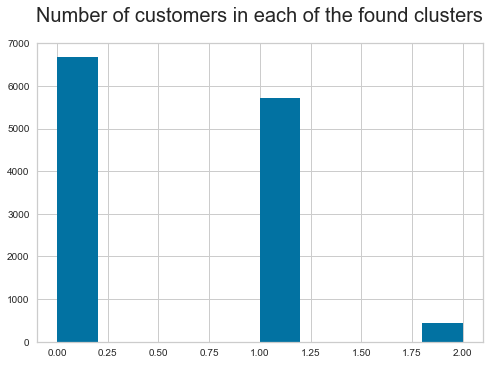

In [45]:
plt.hist(std_rfm2['Cluster'])
plt.title('Number of customers in each of the found clusters', fontsize=20, y=1.05)
plt.show()

## Interpretation of the clusters

As expected, the use of *k* of 3 led to having a small cluster of our best customers, which combined the *Superstars* and the above average ones. However, the interpretation changes a bit since we are looking at different statistics. These valuable customers in cluster 2 have a much higher cost of their maximum purchase and they have also been much more activate in the last 12 months than other customers. Their recency is on the low end, which means they made their last purchase sometime in the latter part of the year.

Our *Uninteresting* customers are now defined by cluster 1. They have been buying low-cost products, they haven't been very active in the last 12 months and a lot of them probably made their last purchase even before that since the recency is pretty high.

Cluster 0 marks the most common type of customer based on this RFM table. These customers tend to spend money on smaller items in the lower price range and they're frequency is below average but not terrible. They have been quite active in the latter part of the year too, so we definitely still see them as active customers who don't use the eshop's services very regularly, but still generate a lot of profit because there is so many of them.

I would say that customer separation on the RFM2 data may be useful for different cases than the first RFM data. It would probably be more useful when analyzing a type of shop, that can expect very regular customer patterns where we can afford to limit the time to for example the last 12 months. Sucha a shop could be a grocery shop. We do not know the exact nature of the goods that our eshop is dealing with, but if it was for example electronics, then their sales would fluctuate throughout the year and their customers would definitely make purchases much less regularly, so for a case such as this one, looking at data on a more global scale probably provides better insight.